In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# WandB Setup - Import W&B and Login

In [ ]:
# Installs the W&B library
!pip install wandb --upgrade

# Imports the wandb library
import wandb
# Login to your W&B account so you can log all your metrics in one place
wandb.login()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.6/215.6 kB 18.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.0 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=03702dfdd4de36e24f5b6343e0bf87bcc0a6ffeb9aeb6dee7e157c5652648aa4
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


# Setup

In [ ]:
!pip install datasets evaluate transformers
import os
import time
import datetime
from google.colab import drive
import re

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup, set_seed

import nltk
nltk.download('punkt')


from datasets import load_metric
import evaluate
!pip install sacrebleu
!pip install bert_score
!pip install rouge_score
bleu_metric = evaluate.load("sacrebleu") # evaluate.load("bleu")
# meteor_metric = evaluate.load('meteor')
rouge_metric = evaluate.load('rouge')

!pip install torch==2.0.0+cu118
import torch
!pip install onnx -Uq
import onnx
import torch.onnx

from nltk.tokenize import sent_tokenize
from evaluate import load
bertscore = load("bertscore")

!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 92.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.7 MB/s eta 0:00:00


In [ ]:
!nvidia-smi

Thu Aug 10 06:12:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Create dataset

In [ ]:
train_dataframe = pd.read_excel('/content/drive/MyDrive/aiml-qa-dataset/aiml-qa-dataset/aiml-qa-train.xlsx')
train_dataframe.head()

,question,answer
0,What is the difference between concatenation v...,Concatenation combines two tensors by adding t...
1,What is the difference between concatenation v...,Concatenation is often used to combine differe...
2,Why are derivatives substracted from weights?,The derivative of the loss function at a point...
3,Why are derivatives substracted from weights?,The intuition behind adjusting the weights by ...
4,Describe a process/pipeline for generating rep...,Select a pretrained model suitable for the tas...


In [ ]:
dev_dataframe = pd.read_excel('/content/drive/MyDrive/aiml-qa-dataset/aiml-qa-dataset/aiml-qa-dev.xlsx')
dev_dataframe.head()

,question,answer1,answer2
0,Does the maximum value of 'n' in the n-gram mo...,The maximum value of n in an n-gram model is n...,The maximum value of 'n' in an n-gram model do...
1,How CNN works?,Convolutional Neural Networks (CNNs) use convo...,CNN is a type of neural network that is common...
2,How is NMT trained? Is it common to use pairs ...,Neural Machine Translation (NMT) is typically ...,"Yes, training NMT models involves using parall..."
3,What is the process of learning POS tags?,The process of learning POS tags involves trai...,POS tags are learned by training machine learn...
4,how to handle multi lingual situations in NLP?,Handling multilingual situations in NLP involv...,It involves techniques such as language identi...


In [ ]:
test_dataframe = pd.read_excel('/content/drive/MyDrive/aiml-qa-dataset/aiml-qa-dataset/aiml-qa-test.xlsx')
test_dataframe.head()

,question,answer1,answer2
0,How we can effectively convert 2D images to 1D?,Converting images to 1D data may not be effect...,"To effectively convert 2D images to 1D, use te..."
1,Can we utilize an autoencoder to perform dimen...,"Yes, autoencoders can be applied to numerical ...","Yes, autoencoders can be used for dimensionali..."
2,What is NLP's current biggest challenge that i...,The main challenges of NLP is finding and coll...,NLP models struggle with tasks that require re...
3,Which problems cannot be solved by Neural netw...,While neural networks have shown great success...,"Neural networks are powerful, but they may str..."
4,Is scaling necessary for SVM?,"Yes, scaling the input data is generally recom...",Scaling the input data is advisable when utili...


# EDA

In [ ]:
def len_text(string):
    length = len(string.split())
    return length

In [ ]:
train_len = train_dataframe[['question', 'answer']].apply(np.vectorize(len_text))
train_len.head()

,question,answer
0,11,21
1,11,38
2,6,34
3,6,35
4,10,26


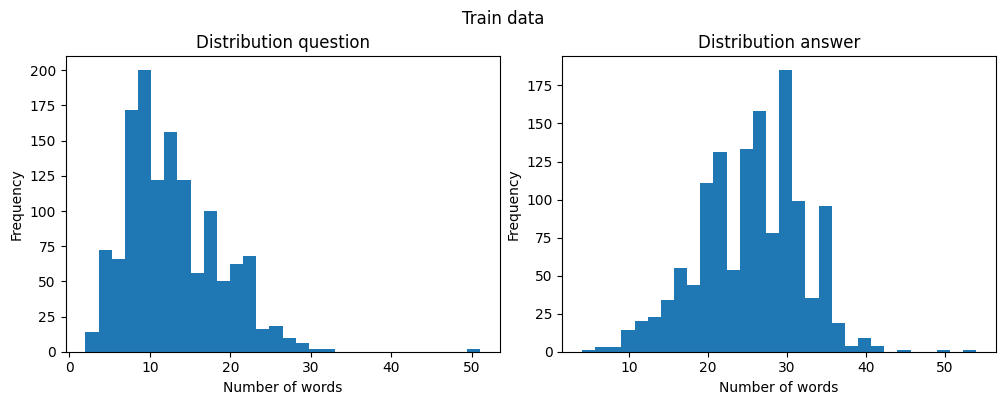

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle("Train data")

data = ['question', 'answer']

# We can set the number of bins with the *bins* keyword argument.
for i, axs in zip(range(len(data)),axs.flatten()):
    axs.hist(train_len[data[i]], bins=30)
    axs.set_xlabel("Number of words")
    axs.set_ylabel("Frequency")
    axs.set_title(f"Distribution {data[i]}")
fig.tight_layout(pad=0.5)
plt.show()

In [ ]:
train_len.describe()

,question,answer
count,1316.000000,1316.000000
mean,12.831307,25.341185
std,5.836854,6.453331
min,2.000000,4.000000
25%,9.000000,21.000000
50%,12.000000,26.000000
75%,17.000000,30.000000
max,51.000000,54.000000


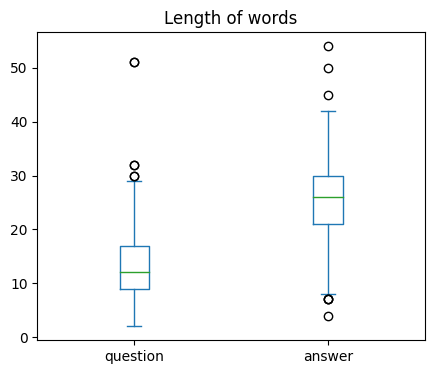

In [ ]:
train_len.plot(kind='box', title='Length of words', figsize=(5,4))
plt.show()

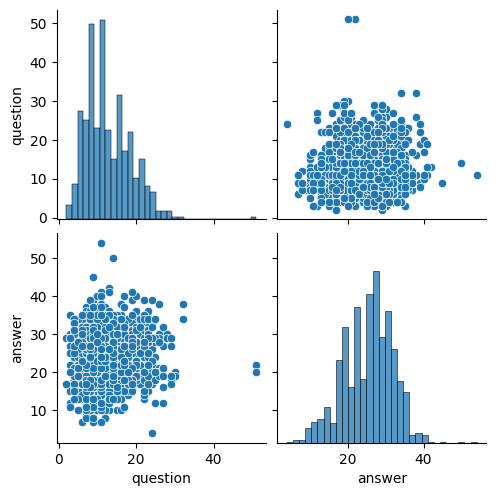

In [ ]:
# pairplot
sns.pairplot(train_len[['question', 'answer']])
# to show
plt.show()

In [ ]:
dev_len = dev_dataframe[['question','answer1','answer2']].apply(np.vectorize(len_text))
dev_len.head()

,question,answer1,answer2
0,23,25,25
1,3,28,34
2,21,24,17
3,8,26,26
4,8,26,28


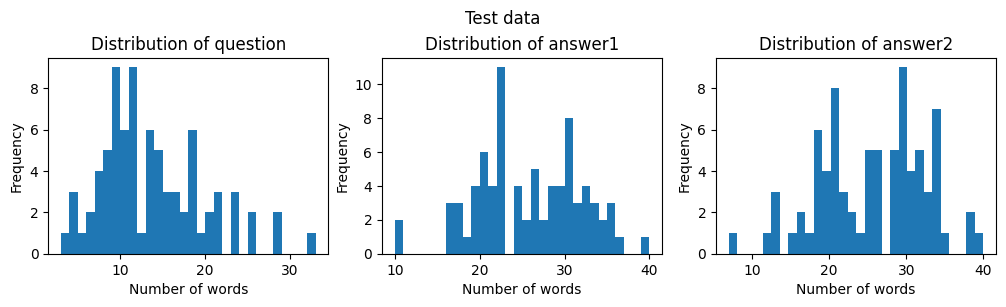

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
fig.suptitle("Test data")

data = ['question','answer1','answer2']

# We can set the number of bins with the *bins* keyword argument.
for i, axs in zip(range(len(data)),axs.flatten()):
    axs.hist(dev_len[data[i]], bins=30)
    axs.set_xlabel("Number of words")
    axs.set_ylabel("Frequency")
    axs.set_title(f"Distribution of {data[i]}")
fig.tight_layout(pad=0.5)
plt.show()

In [ ]:
dev_len.describe()

,question,answer1,answer2
count,80.000000,80.000000,80.000000
mean,13.312500,25.325000,25.675000
std,6.153303,6.166005,6.913159
min,3.000000,10.000000,7.000000
25%,9.000000,21.000000,21.000000
50%,11.500000,25.500000,26.000000
75%,17.250000,30.000000,31.000000
max,33.000000,40.000000,40.000000


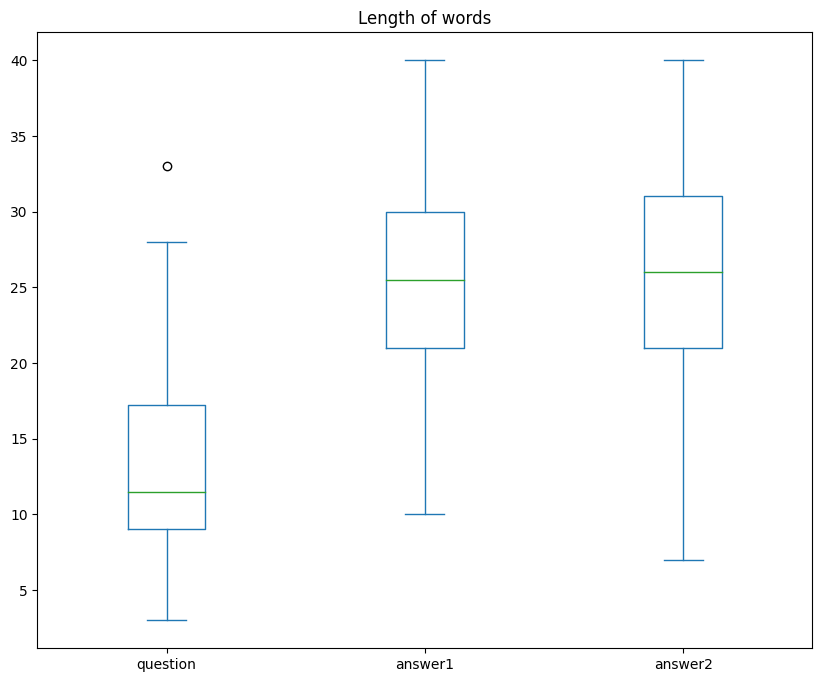

In [ ]:
dev_len.plot(kind='box', title='Length of words', figsize=(10,8))
plt.show()

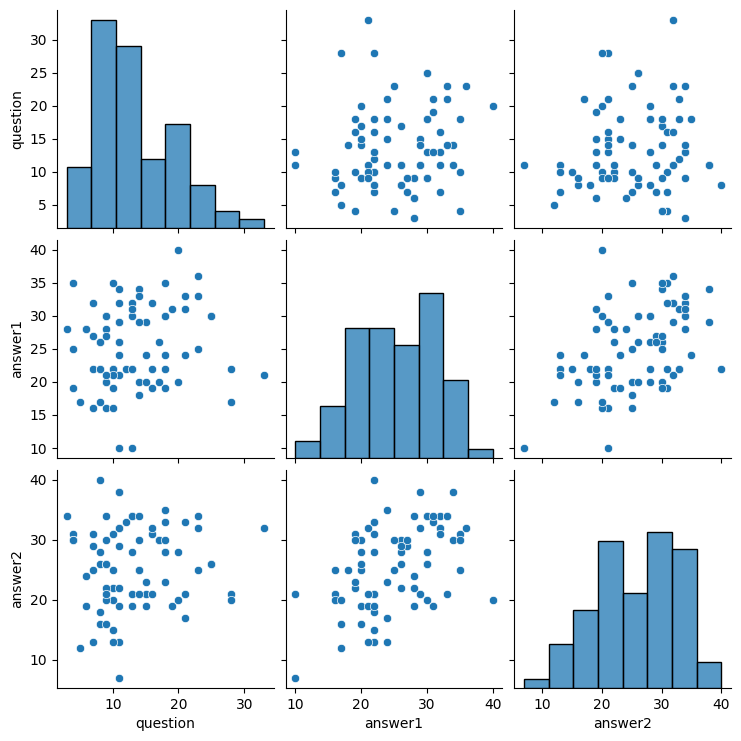

In [ ]:
# pairplot
sns.pairplot(dev_len)
# to show
plt.show()

In [ ]:
test_len = test_dataframe[['question','answer1','answer2']].apply(np.vectorize(len_text))
test_len.head()

,question,answer1,answer2
0,9,27,30
1,12,29,30
2,13,33,18
3,8,28,27
4,5,33,36


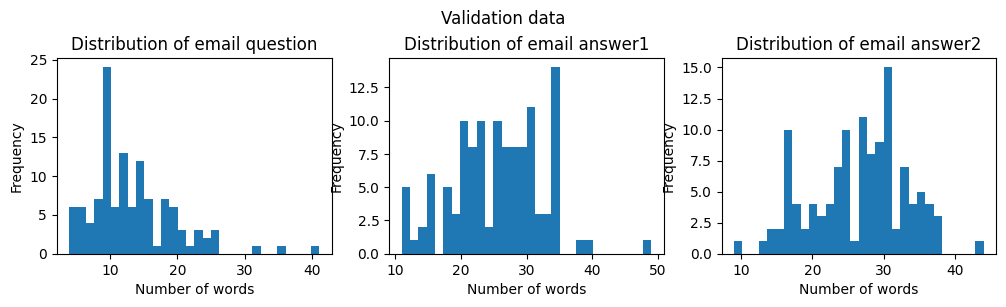

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
fig.suptitle("Validation data")

data = ['question','answer1','answer2']

# We can set the number of bins with the *bins* keyword argument.
for i, axs in zip(range(len(data)),axs.flatten()):
    axs.hist(test_len[data[i]], bins=30)
    axs.set_xlabel("Number of words")
    axs.set_ylabel("Frequency")
    axs.set_title(f"Distribution of email {data[i]}")
fig.tight_layout(pad=0.5)
plt.show()

In [ ]:
test_len.describe()

,question,answer1,answer2
count,120.000000,120.000000,120.000000
mean,13.425000,25.491667,26.400000
std,6.341358,6.867284,6.581614
min,4.000000,11.000000,9.000000
25%,9.000000,21.000000,22.000000
50%,12.000000,26.000000,27.000000
75%,16.000000,30.000000,30.250000
max,41.000000,49.000000,44.000000


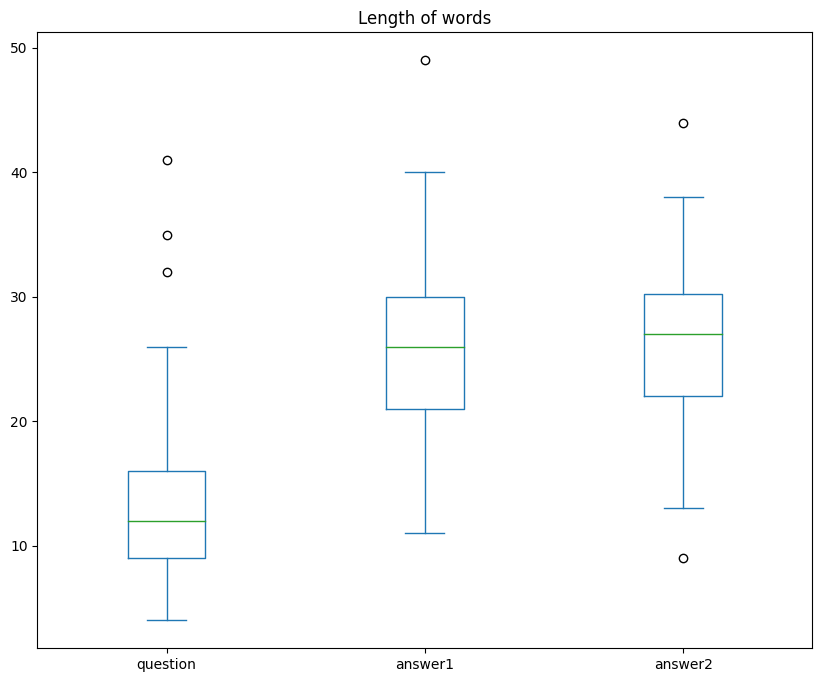

In [ ]:
test_len.plot(kind='box', title='Length of words', figsize=(10,8))
plt.show()

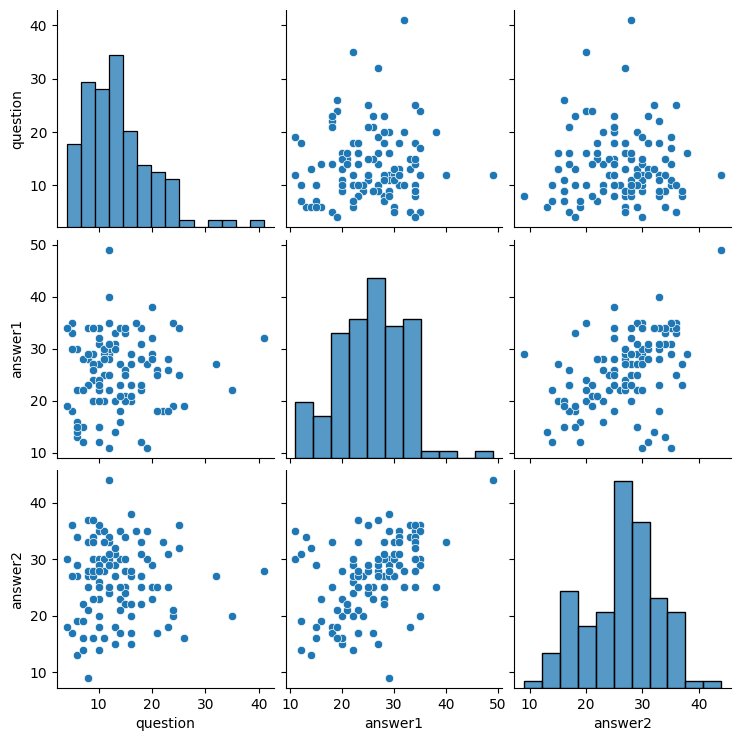

In [ ]:
# pairplot
sns.pairplot(test_len)
# to show
plt.show()

# Initialize Hyperparameters for WandB

In [ ]:
# Capture a dictionary of hyperparameters with config
config = dict(epochs = 5,
              warmup_steps = 1e2,
              batch_size = 16, #[1, 2, 4, 8, 16, 32, 64]
              epsilon = 1e-6, #[1e-5, 1e-6, 1e-7]
              gpt2_type ='olm/olm-gpt2-dec-2022', # ['distilgpt2', 'gpt2','Ar4ikov/gpt2-650k-stable-diffusion-prompt-generator','crumb/gpt2023','olm/olm-gpt2-dec-2022']
              learning_rate = 0.0001, #[0.00005, 0.0001, 0.0005, 0.001]
              max_length = 70, #[80, 60, 70, 90]
              )

# Initializes a new W&B run. Each run is single execution of the training script.
wandb.init(project="qahyperopt", config=config)
config = wandb.config

# GPT2 Tokenizer

Although the defaults take care of this,I thought I'd show that you can specify some of the special tokens.

In [ ]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained(config.gpt2_type, bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>')

# default to left padding
tokenizer.padding_side = "left"

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50265
The end of sequence token <|endoftext|> has the id 50266
The padding token <|pad|> has the id 50267


# PyTorch Datasets & Dataloaders


GPT2 is a large model. Increasing the batch size above 2 has lead to out of memory problems. This can be mitigated by accumulating the gradients but that is out of scope here.

In [ ]:
batch_size = config.batch_size
batch_size

32

I'm using the standard PyTorch approach of loading data in using a [dataset class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

I'm passing in the tokenizer as an argument but normally I would  instantiate it within the class.

In [ ]:
class GPT2Dataset(Dataset):

  def __init__(self,question_list,answer_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for question, answer in zip(question_list,answer_list):

      encodings_dict = tokenizer('<|startoftext|>' + '<question>' + question + '<answer>' + answer  + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

To understand how I've used the tokenizer, it's worth reading [the docs](https://huggingface.co/transformers/main_classes/tokenizer.html). I've wrapped each bio in the bos and eos tokens.

Every tensor passed to the model should be the same length.

If the bio is shorter than 768 tokens, it will be padded to a length of 768 using the padding token. In addition, an attention mask will be returned that needs to be passed to the model to tell it to ignore the padding tokens.

If the bio is longer than 768 tokens, it will be truncated without the eos_token. This isn't a problem.

In [ ]:
train_dataset = GPT2Dataset(train_dataframe['question'],
                            train_dataframe['answer'],
                            tokenizer,
                            gpt2_type=config.gpt2_type,
                            max_length=config.max_length)
train_dataset

In [ ]:
len(train_dataset)

1316

In [ ]:
tokenizer.decode(next(iter(train_dataset[0])),skip_special_tokens=True)

'<question>What is the difference between concatenation vs. summation of two tensors?<answer>Concatenation combines two tensors by adding them together along a specified dimension. Summation adds the elements of two tensors together element-wise.'

In [ ]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = config.batch_size # Trains with this batch size.
        )

In [ ]:
class GPT2Dataset_EVAL(Dataset):

  def __init__(self,question_list, answer1_list, answer2_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []
    self.answer1 = []
    self.answer2 = []

    for question, answer1, answer2 in zip(question_list, answer1_list, answer2_list):

      encodings_dict = tokenizer('<|startoftext|>' + '<question>' + question + '<answer>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
      self.answer1.append(answer1)
      self.answer2.append(answer2)

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx], self.answer1[idx], self.answer2[idx]

In [ ]:
val_dataset = GPT2Dataset_EVAL(dev_dataframe['question'],
                               dev_dataframe['answer1'],
                               dev_dataframe['answer2'],
                               tokenizer, gpt2_type=config.gpt2_type,
                               max_length=config.max_length)

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = config.batch_size # Evaluate with this batch size.
        )

In [ ]:
len(val_dataset)

80

In [ ]:
tokenizer.decode(next(iter(val_dataset[0])),skip_special_tokens=True)

"<question>Does the maximum value of 'n' in the n-gram model depend on the average number of words per sentence in the training data?<answer>"

In [ ]:
test_dataset = GPT2Dataset_EVAL(test_dataframe['question'],
                                test_dataframe['answer1'],
                                test_dataframe['answer2'],
                                tokenizer, gpt2_type=config.gpt2_type,
                                max_length=config.max_length)
test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = config.batch_size # Evaluate with this batch size.
        )

In [ ]:
len(test_dataset)

120

# Finetune GPT2 Language Model

In [ ]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained(config.gpt2_type, output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained(config.gpt2_type, config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
# some parameters I cooked up that work reasonably well

epochs = config.epochs
learning_rate = config.learning_rate
warmup_steps = config.warmup_steps
epsilon = config.epsilon

# this produces sample output every 100 steps
sample_every = 100

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

In [ ]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [ ]:
from accelerate import Accelerator

accelerator = Accelerator()

model, optimizer, training_dataloader, scheduler = accelerator.prepare(model, optimizer, train_dataloader, scheduler)

device = accelerator.device
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50268, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50268, bias=False)
)

In [ ]:
def return_first_match(string):
    try:
        result = re.search("(?<=<answer>).*",string).group()
    except Exception or IndexError:
        result = ''
    return result

In [ ]:
# Metrics
def compute_metric(preds, labels):
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_preds = [" ".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_preds = [return_first_match(string) for string in decoded_preds]
    bleu = bleu_metric.compute(predictions=decoded_preds, references=labels)['score']
    # meteor = meteor_metric.compute(predictions=decoded_preds, references=labels)['meteor'] *100
    rouge = rouge_metric.compute(predictions=decoded_preds, references=labels)
    rouge_R1, rouge_R2, rouge_RL, rouge_RLsum = rouge['rouge1']*100, rouge['rouge2']*100, rouge['rougeL']*100, rouge['rougeLsum']*100
    bert = bertscore.compute(predictions=decoded_preds, references=labels, model_type="distilbert-base-uncased")
    bert_precision, bert_recall, bert_f1 = np.mean(bert['precision']), np.mean(bert['recall']), np.mean(bert['f1'])
    return bleu, rouge_R1, rouge_R2, rouge_RL, rouge_RLsum, bert_precision, bert_recall, bert_f1

In [ ]:
total_t0 = time.time()

wandb.watch(model, criterion=None, log="all", log_freq=10)

training_stats = []

model = model.to(device)

new_eval_bert_precision, new_eval_bert_recall, new_eval_bert_f1 = 0, 0, 0
train_batch_step = 0
train_epoch_step = 0
val_batch_step = 0
val_epoch_step = 0

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0
    bleu_train_total = 0
    meteor_train_total = 0
    rouge_train_total = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(b_input_ids,
                        labels=b_labels,
                        attention_mask = b_masks,
                        token_type_ids=None)

        loss = outputs[0]
        batch_loss = loss.item()
        total_train_loss += batch_loss
        train_batch_step += 1
        wandb.log({'train_batch_no': train_batch_step, 'batch_train_loss': loss})

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('Batch {:>5,}  of  {:>5,}. Loss: {:>5,}. Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            prompt = "<|startoftext|>"

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,
                                    top_k=50,
                                    max_length = 200,
                                    top_p=0.95,
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=False)))

            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)
    train_epoch_step += 1
    wandb.log({'train_epoch_no': train_epoch_step,'train_epoch_loss': avg_train_loss})

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0
    bleu_eval_total = 0
    rouge_R1_eval_total = 0
    rouge_R2_eval_total = 0
    rouge_RL_eval_total = 0
    rouge_RLsum_eval_total = 0
    bert_precision_eval_total = 0
    bert_recall_eval_total = 0
    bert_f1_eval_total = 0

    for batch, mask, answer1, answer2 in validation_dataloader:

        b_input_ids = batch.to(device)
        b_labels = batch.to(device)
        b_masks = mask.to(device)

        with torch.no_grad():

          outputs  = model(b_input_ids, token_type_ids=None, attention_mask = b_masks, labels=b_labels)
          # predictions = model.generate(input_ids = b_input_ids, attention_mask = b_masks, max_new_tokens=80, num_beams=5, no_repeat_ngram_size=2, num_return_sequences=1, early_stopping=True, pad_token_id = tokenizer.pad_token_id)
          # predictions = model.generate(input_ids = b_input_ids, attention_mask = b_masks, max_new_tokens=40, do_sample=True, top_k=30, top_p=0.95, pad_token_id = tokenizer.pad_token_id)
          # predictions = model.generate(input_ids = b_input_ids, attention_mask = b_masks, max_new_tokens=40, penalty_alpha=0.6, top_k=20, pad_token_id = tokenizer.pad_token_id)
          predictions = model.generate(input_ids = b_input_ids,
                                       attention_mask = b_masks,
                                       max_new_tokens=40,
                                       pad_token_id = tokenizer.pad_token_id,
          )
          loss = outputs[0]
          batch_loss = loss.item()
          label = answer1, answer2
          labels = [[i, j] for i, j in zip(answer1, answer2)]
          preds, labels = predictions, labels
          bleu, rouge_R1, rouge_R2, rouge_RL, rouge_RLsum, bert_precision, bert_recall, bert_f1 = compute_metric(preds, labels)
          val_batch_step += 1
          wandb.log({'val_batch_no': val_batch_step,
                     'val_batch_loss': batch_loss,
                     'val_batch_bleu': bleu,
                     'val_batch_rouge_R1': rouge_R1,
                     'val_batch_rouge_R2': rouge_R2,
                     'val_batch_rouge_RL': rouge_RL,
                     'val_batch_rouge_RLsum': rouge_RLsum,
                     'val_batch_bert_precision': bert_precision,
                     'val_batch_bert_recall':bert_recall,
                     'val_batch_bert_f1':bert_f1,
                     })

        batch_loss = loss.item()
        total_eval_loss += batch_loss
        bleu_eval_total += bleu
        rouge_R1_eval_total += rouge_R1
        rouge_R2_eval_total += rouge_R2
        rouge_RL_eval_total += rouge_RL
        rouge_RLsum_eval_total += rouge_RLsum
        bert_precision_eval_total += bert_precision
        bert_recall_eval_total += bert_recall
        bert_f1_eval_total += bert_f1

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    avg_eval_bleu = bleu_eval_total / len(validation_dataloader)
    avg_eval_rouge_R1 = rouge_R1_eval_total / len(validation_dataloader)
    avg_eval_rouge_R2 = rouge_R2_eval_total / len(validation_dataloader)
    avg_eval_rouge_RL = rouge_RL_eval_total / len(validation_dataloader)
    avg_eval_rouge_RLsum = rouge_RLsum_eval_total / len(validation_dataloader)
    avg_eval_bert_precision = bert_precision_eval_total / len(validation_dataloader)
    avg_eval_bert_recall = bert_recall_eval_total / len(validation_dataloader)
    avg_eval_bert_f1 = bert_f1_eval_total / len(validation_dataloader)

    if (avg_eval_bert_precision, avg_eval_bert_recall, avg_eval_bert_f1) > (new_eval_bert_precision, new_eval_bert_recall, new_eval_bert_f1):
      new_eval_bert_precision, new_eval_bert_recall, new_eval_bert_f1 = avg_eval_bert_precision, avg_eval_bert_recall, avg_eval_bert_f1
      print(f"Model Saved during epoch number {epoch_i+1}")
      output_dir = './model_save/'
      if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        model_to_save = model.module if hasattr(model, 'module') else model
        model_to_save.save_pretrained(output_dir)
        tokenizer.save_pretrained(output_dir)

    validation_time = format_time(time.time() - t0)

    val_epoch_step += 1
    wandb.log({'val_epoch_no': val_epoch_step,
               'val_epoch_loss': avg_val_loss,
               'val_epoch_bleu': avg_eval_bleu,
               'val_epoch_rouge_R1': avg_eval_rouge_R1,
               'val_epoch_rouge_R2': avg_eval_rouge_R2,
               'val_epoch_rouge_RL': avg_eval_rouge_RL,
               'val_epoch_rouge_RLsum': avg_eval_rouge_RLsum,
               'val_epoch_bert_precision': avg_eval_bert_precision,
               'val_epoch_bert_recall': avg_eval_bert_recall,
               'val_epoch_bert_f1': avg_eval_bert_f1})

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation BLEU: {0:.2f}".format(avg_eval_bleu))
    print("  Validation ROUGE_R1: {0:.2f}".format(avg_eval_rouge_R1))
    print("  Validation ROUGE_R2: {0:.2f}".format(avg_eval_rouge_R2))
    print("  Validation ROUGE_RL: {0:.2f}".format(avg_eval_rouge_RL))
    print("  Validation ROUGE_RLsum: {0:.2f}".format(avg_eval_rouge_RLsum))
    print("  Validation BERT_PREDICTION: {0:.2f}".format(avg_eval_bert_precision))
    print("  Validation BERT_RECALL: {0:.2f}".format(avg_eval_bert_recall))
    print("  Validation BERT_F1: {0:.2f}".format(avg_eval_bert_f1))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. BLEU': avg_eval_bleu,
            'Valid. ROUGE_R1': avg_eval_rouge_R1,
            'Valid. ROUGE_R2': avg_eval_rouge_R2,
            'Valid. ROUGE_RL': avg_eval_rouge_RL,
            'Valid. ROUGE_RLsum': avg_eval_rouge_RLsum,
            'Valid. BERT_PREDICTION': avg_eval_bert_precision,
            'Valid. BERT_RECALL': avg_eval_bert_recall,
            'Valid. BERT_F1': avg_eval_bert_f1,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )


print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...

  Average training loss: 2.61
  Training epoch took: 0:00:43

Running Validation...


Model Saved during epoch number 1
  Validation Loss: 1.19
  Validation BLEU: 11.57
  Validation ROUGE_R1: 32.60
  Validation ROUGE_R2: 14.53
  Validation ROUGE_RL: 27.72
  Validation ROUGE_RLsum: 27.63
  Validation BERT_PREDICTION: 0.82
  Validation BERT_RECALL: 0.81
  Validation BERT_F1: 0.81
  Validation took: 0:00:40

======== Epoch 2 / 5 ========
Training...

  Average training loss: 1.41
  Training epoch took: 0:00:38

Running Validation...
Model Saved during epoch number 2
  Validation Loss: 0.59
  Validation BLEU: 14.54
  Validation ROUGE_R1: 35.78
  Validation ROUGE_R2: 17.34
  Validation ROUGE_RL: 30.18
  Validation ROUGE_RLsum: 30.28
  Validation BERT_PREDICTION: 0.84
  Validation BERT_RECALL: 0.83
  Validation BERT_F1: 0.83
  Validation took: 0:00:39

======== Epoch 3 / 5 ========
Training...

  Average training loss: 0.93
  Training epoch took: 0:00:38

Running Validation...
  Validation Loss: 0.63
  Validation BLEU: 14.89
  Validation ROUGE_R1: 37.32
  Validation ROUGE_R2:

Let's view the summary of the training process.

In [ ]:
# Display floats with two decimal places.
#pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. BLEU,Valid. ROUGE_R1,Valid. ROUGE_R2,Valid. ROUGE_RL,Valid. ROUGE_RLsum,Valid. BERT_PREDICTION,Valid. BERT_RECALL,Valid. BERT_F1,Training Time,Validation Time
epoch,,,,,,,,,,,,
1,2.611281,1.194386,11.574382,32.596743,14.530950,27.719749,27.634990,0.822037,0.805035,0.812221,0:00:43,0:00:40
2,1.409464,0.593621,14.544552,35.783034,17.339358,30.176017,30.282182,0.839704,0.830807,0.833799,0:00:38,0:00:39
3,0.926664,0.632281,14.886296,37.324404,18.076623,30.536370,30.602393,0.838363,0.837904,0.836908,0:00:38,0:00:35
4,0.561019,0.796653,16.797978,38.158167,18.540534,31.357825,31.248947,0.840260,0.839663,0.838862,0:00:36,0:00:38
5,0.340163,0.742402,17.874413,39.630746,20.380678,33.122901,33.089988,0.847809,0.842390,0.843848,0:00:36,0:00:36


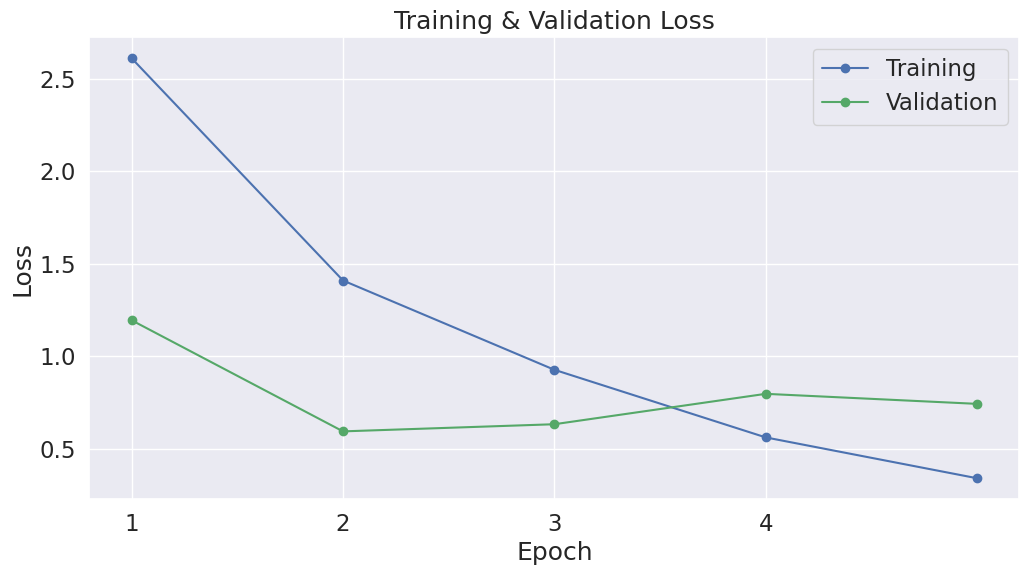

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Display Model Info

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50268, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

# Saving Fine-Tuned Model

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!ls -l --block-size=K ./model_save/

total 487640K
-rw-r--r-- 1 root root      1K Aug 10 06:14 added_tokens.json
-rw-r--r-- 1 root root      1K Aug 10 06:14 config.json
-rw-r--r-- 1 root root      1K Aug 10 06:14 generation_config.json
-rw-r--r-- 1 root root    453K Aug 10 06:14 merges.txt
-rw-r--r-- 1 root root 486173K Aug 10 06:14 pytorch_model.bin
-rw-r--r-- 1 root root      1K Aug 10 06:14 special_tokens_map.json
-rw-r--r-- 1 root root      2K Aug 10 06:14 tokenizer_config.json
-rw-r--r-- 1 root root    983K Aug 10 06:14 vocab.json


In [ ]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

-rw-r--r-- 1 root root 475M Aug 10 06:14 ./model_save/pytorch_model.bin


In [ ]:
# Copy the model files to a directory in your Google Drive.
# !cp -r ./model_save/ '/content/drive/MyDrive'
!zip -r model_save.zip model_save/
!cp model_save.zip /content/drive/MyDrive
# # Load a trained model and vocabulary that you have fine-tuned
#model = GPT2LMHeadModel.from_pretrained(output_dir)
#tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
#model.to(device)

  adding: model_save/ (stored 0%)
  adding: model_save/pytorch_model.bin (deflated 7%)
  adding: model_save/merges.txt (deflated 54%)
  adding: model_save/added_tokens.json (deflated 36%)
  adding: model_save/vocab.json (deflated 68%)
  adding: model_save/generation_config.json (deflated 24%)
  adding: model_save/tokenizer_config.json (deflated 75%)
  adding: model_save/config.json (deflated 50%)
  adding: model_save/special_tokens_map.json (deflated 74%)


In [ ]:
wandb.finish()

batch_train_loss,█▅▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_batch_no,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_epoch_loss,█▄▃▂▁
train_epoch_no,▁▃▅▆█
val_batch_bert_f1,▁▃▁▆▆▄▆▆▅▅▆▇▆█▇
val_batch_bert_precision,▁▄▁▆▇▅▅▆▅▄▇▇▇██
val_batch_bert_recall,▂▃▁▆▅▄▆▆▅▅▆▆▅█▆
val_batch_bleu,▁▁▁▃▆▁▂▅▃▃▇▆▅█▅
val_batch_loss,███▂▁▁▃▂▁▅▃▃▄▃▂
val_batch_no,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
val_batch_rouge_R1,▁▃▁▅▅▁▅▇▃▅▆▆██▄


# Testing with Saved model

In [ ]:
# Load a trained model and vocabulary that you have fine-tuned
model = GPT2LMHeadModel.from_pretrained('/content/model_save')
tokenizer = GPT2Tokenizer.from_pretrained('/content/model_save')
model.to('cpu')

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50268, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50268, bias=False)
)

In [ ]:
def eval_encoding(question):
  encode_body = '<|startoftext|>' + '<question> '+ question
  encode_subject = '<answer>'
  return encode_body, encode_subject

def return_first_match(string):
    try:
        result = re.search("(?<=<answer>).*",string).group()
    except Exception or IndexError:
        result = ''
    return result

def qaaiml(question):
    encodings_dict = tokenizer(eval_encoding(question)[0],
                           eval_encoding(question)[1],
                           truncation=True, max_length=512,
                           padding="max_length",
                           return_tensors = 'pt')
    tokenizer.padding_side = "left"

    # prediction = model.generate(**encodings_dict, max_new_tokens=40, num_beams=5, no_repeat_ngram_size=2, num_return_sequences=1, early_stopping=True, pad_token_id = tokenizer.pad_token_id)
    # prediction = model.generate(**encodings_dict, max_new_tokens=40, do_sample=True, top_k=0, top_p=0.95, pad_token_id = tokenizer.pad_token_id)
    prediction = model.generate(**encodings_dict,
                                max_new_tokens=40,
                                penalty_alpha=0.05,
                                top_k=10,
                                pad_token_id = tokenizer.pad_token_id,
    )
    decoded_preds = tokenizer.decode(prediction[0], skip_special_tokens=True)
    decoded_preds = return_first_match(decoded_preds).strip()
    return decoded_preds

In [ ]:
question = 'What is machine learning?'

In [ ]:
qaaiml(question)

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


'1.Machine learning is a type of artificial intelligence that is used to learn and interpret data from data. It is a type of artificial intelligence that is used to make predictions and make decisions based'

In [ ]:
wandb.finish()

# Test dataset metrics

In [ ]:
# Load a trained model and vocabulary that you have fine-tuned
model = GPT2LMHeadModel.from_pretrained('/content/model_save')
tokenizer = GPT2Tokenizer.from_pretrained('/content/model_save')
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50268, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50268, bias=False)
)

In [ ]:
t0 = time.time()
model.eval()

testing_stats = []
total_test_loss = 0
bert_precision_test_total = 0
bert_recall_test_total = 0
bert_f1_test_total = 0
test_batch_step = 0
test_epoch_step = 0

# Evaluate data for one epoch
for batch, mask, answer1, answer2 in test_dataloader:

  b_input_ids = batch.to(device)
  b_labels = batch.to(device)
  b_masks = mask.to(device)
  with torch.no_grad():
    predictions = model.generate(input_ids = b_input_ids,
                                 attention_mask = b_masks,
                                 max_new_tokens=35,
                                 pad_token_id = tokenizer.pad_token_id)

    label = answer1, answer2
    labels = [[i, j] for i, j in zip(answer1, answer2)]
    preds, labels = predictions, labels
    bert_precision, bert_recall, bert_f1 = compute_metric(preds, labels)

    bert_precision_test_total += bert_precision
    bert_recall_test_total += bert_recall
    bert_f1_test_total += bert_f1

  avg_test_bert_precision = bert_precision_test_total / len(test_dataloader)
  avg_test_bert_recall = bert_recall_test_total / len(test_dataloader)
  avg_test_bert_f1 = bert_f1_test_total / len(test_dataloader)

test_time = format_time(time.time() - t0)

print("Testing...")
print("  Test BERT_PRECISION: {0:.2f}".format(avg_test_bert_precision))
print("  Test BERT_RECALL: {0:.2f}".format(avg_test_bert_recall))
print("  Test BERT_F1: {0:.2f}".format(avg_test_bert_f1))
print("  Test Time: {:}".format(test_time))

# Record all statistics from this epoch.
testing_stats.append(
        {
            'Testing BERT_PRECISION': avg_test_bert_precision,
            'Testing BERT_RECALL': avg_test_bert_recall,
            'Testing BERT_F1': avg_test_bert_f1,
            'Testing Time': test_time
        }
    )

print("")
print("Testing complete!")
print("Total testing took {:} (h:mm:ss)".format(format_time(time.time()-t0)))

ValueError: ignored

These aren't bad at all!
